In [1]:
import sys
import time
import numpy as np
import os.path as osp
import tensorflow as tf
import matplotlib.pyplot as plt

import tf_lab.point_clouds.in_out as pio
import tf_lab.models.point_net_based_AE as pnAE

from tf_lab.fundamentals.utils import set_visible_GPUs

from tf_lab.point_clouds.in_out import PointCloudDataSet
from tf_lab.point_clouds.vae import VariationalAutoencoder
from tf_lab.point_clouds.autoencoder import Configuration as Conf
import tf_lab.point_clouds.various_encoders_decoders as enc_dec
from tf_lab.autopredictors.scripts.helper import shape_net_category_to_synth_id, match_incomplete_to_complete_data

from tf_lab.autopredictors.evaluate.basics import eval_model, read_saved_epochs
from tf_lab.autopredictors.plotting.basics import plot_original_pclouds_vs_reconstructed,\
                                                  plot_train_val_test_curves, plot_reconstructions_at_epoch


from general_tools.in_out.basics import create_dir, delete_files_in_directory, files_in_subdirs
from geo_tool import Point_Cloud

/orions4-zfs/projects/lins2/Panos_Space/Git_Repos/geo_tool/solids/mesh.py:26: UserWarning: Mayavi library was not found. Some graphics utilities will be disabled.
  warnings.warn('Mayavi library was not found. Some graphics utilities will be disabled.')


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
class_type = raw_input('Give me the class type.\n').lower()
class_syn_id = shape_net_category_to_synth_id()[class_type]
experiment_name = 'chamfer_full_shapes_' + class_syn_id + '_vae_z_300_no_noise'

seed = 42
np.random.seed(seed)
tf.set_random_seed(seed)

top_data_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/'
full_pclouds_path = osp.join(top_data_dir, 'ShapeNetPointClouds/from_manifold_meshes/1024/', class_syn_id)

train_dir = osp.join(top_data_dir, 'OUT/models/variational')
train_dir = osp.join(train_dir, experiment_name)
create_dir(train_dir)

Give me the class type.
chair


'/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/variational/chamfer_full_shapes_03001627_vae_z_300_no_noise'

In [4]:
full_file_names = pio.load_filenames_of_input_data(full_pclouds_path)
full_pclouds, full_model_names, class_ids = pio.load_crude_point_clouds(file_names=full_file_names, n_threads=15)
print '%d files containing complete point clouds were found.' % (len(full_pclouds), )

6778 files containing complete point clouds were found.


In [5]:
train_data_, val_data_, test_data_ = pio.train_validate_test_split([full_pclouds, 
                                                                    full_model_names],
                                                                    train_perc=0.95,
                                                                    validate_perc=0.0,
                                                                    test_perc=0.05,                                                                   
                                                                    seed=seed)

train_data = PointCloudDataSet(train_data_[0], labels=train_data_[1])
test_data = PointCloudDataSet(test_data_[0], labels=test_data_[1])

In [6]:
def reset_graph():
    if 'sess' in globals() and sess:
        sess.close()
    tf.reset_default_graph()

set_visible_GPUs([1])

conf = Conf(n_input = [1024, 3],
            training_epochs = 1000,
            batch_size = 50,
            loss = 'chamfer',
            train_dir = train_dir,
            loss_display_step = 1,
            saver_step = 5,
            learning_rate = 0.0001,
            saver_max_to_keep = 300,
            encoder = enc_dec.encoder_1dcovnv_5_points,
            decoder = enc_dec.decoder_only_with_fc,
            spatial_trans = False,
            denoising = False,
            n_z = 300
           )

reset_graph()
vae = VariationalAutoencoder(experiment_name, conf)
vae.train(train_data, conf)
# gauss_augment = {'mu': 0, 'sigma': 0.05},
#             z_rotate = True

('Epoch:', '0001', 'training time (minutes)=', '0.2564', 'loss=', '1534.453506470')
('Epoch:', '0002', 'training time (minutes)=', '0.2453', 'loss=', '562.930919886')
('Epoch:', '0003', 'training time (minutes)=', '0.2477', 'loss=', '439.563994169')
('Epoch:', '0004', 'training time (minutes)=', '0.1882', 'loss=', '379.997467041')
('Epoch:', '0005', 'training time (minutes)=', '0.2419', 'loss=', '350.492942572')
('Epoch:', '0006', 'training time (minutes)=', '0.2403', 'loss=', '331.248516798')
('Epoch:', '0007', 'training time (minutes)=', '0.2405', 'loss=', '316.815241575')
('Epoch:', '0008', 'training time (minutes)=', '0.2402', 'loss=', '304.755732298')
('Epoch:', '0009', 'training time (minutes)=', '0.2405', 'loss=', '296.357020259')
('Epoch:', '0010', 'training time (minutes)=', '0.2414', 'loss=', '288.328629494')
('Epoch:', '0011', 'training time (minutes)=', '0.2410', 'loss=', '282.526574254')
('Epoch:', '0012', 'training time (minutes)=', '0.2211', 'loss=', '276.705159068')
('E

[(1, 1534.4535064697266, 15.382102012634277),
 (2, 562.93091988563538, 14.71806287765503),
 (3, 439.56399416923523, 14.860307931900024),
 (4, 379.99746704101562, 11.29243803024292),
 (5, 350.49294257164001, 14.511497974395752),
 (6, 331.24851679801941, 14.415019035339355),
 (7, 316.81524157524109, 14.43065619468689),
 (8, 304.75573229789734, 14.410354852676392),
 (9, 296.3570202589035, 14.429634809494019),
 (10, 288.32862949371338, 14.483703136444092),
 (11, 282.52657425403595, 14.460437059402466),
 (12, 276.7051590681076, 13.267773151397705),
 (13, 269.63322567939758, 14.449529886245728),
 (14, 263.68303072452545, 14.866034984588623),
 (15, 256.33621883392334, 14.489581823348999),
 (16, 248.28577196598053, 14.45879316329956),
 (17, 243.20788264274597, 14.493607997894287),
 (18, 238.94477987289429, 14.432285070419312),
 (19, 235.89323425292969, 14.415019035339355),
 (20, 233.72058939933777, 13.805444955825806),
 (21, 231.65513014793396, 14.506666898727417),
 (22, 228.94858753681183, 14

Model restored in epoch 5.
[ 436.65400028  433.53120422]
Model restored in epoch 105.
[ 211.47844231  213.11274974]
Model restored in epoch 205.
[ 192.34215808  191.78265889]
Model restored in epoch 305.
[ 187.5576328   185.56347402]
Model restored in epoch 405.
[ 181.93166733  183.39651998]
Model restored in epoch 505.
[ 183.14258325  182.71740468]
Model restored in epoch 605.
[ 184.09025979  185.81589508]
Model restored in epoch 705.
[ 179.61969864  182.00204468]
Model restored in epoch 805.
[ 179.31278884  178.35374451]
Model restored in epoch 905.
[ 178.52437592  180.04837799]


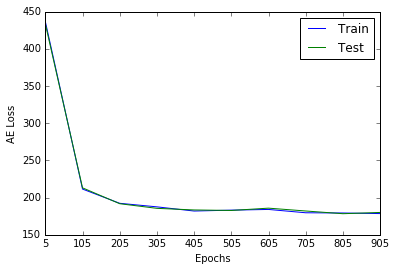

In [31]:
# saved_epochs = read_saved_epochs(conf.train_dir)
# epochs = saved_epochs[::len(saved_epochs)/10]
# stats = eval_model(vae, conf, [train_data, test_data], epochs=epochs, verbose=True)
# top_save_dir = osp.join(top_data_dir, 'OUT/model_evaluation/variational/', experiment_name)
# plot_train_val_test_curves(stats, top_save_dir, has_validation=False, best_epoch=None, show=True)

251.836


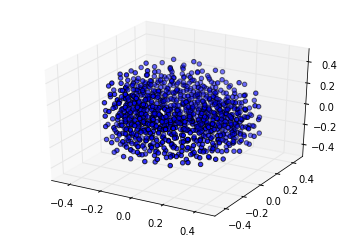

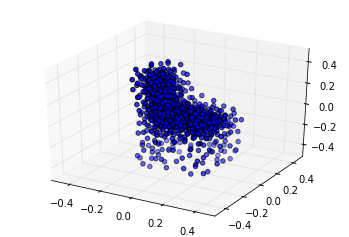

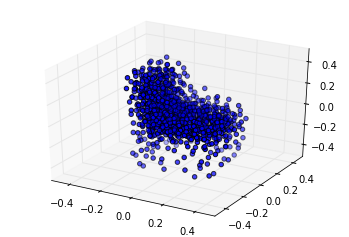

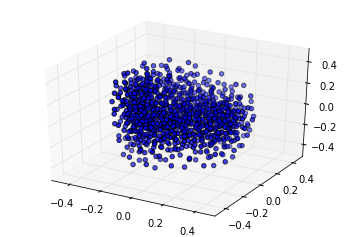

In [46]:
batch_size = conf.batch_size
feed = test_data.next_batch(batch_size)[0].reshape([batch_size] + conf.n_input)
res, loss = vae.reconstruct(feed)
print loss
Point_Cloud(points=res[0]).plot(in_u_sphere=True);
Point_Cloud(points=res[1]).plot(in_u_sphere=True);
Point_Cloud(points=res[2]).plot(in_u_sphere=True);
Point_Cloud(points=res[3]).plot(in_u_sphere=True);

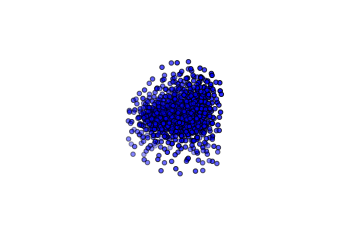

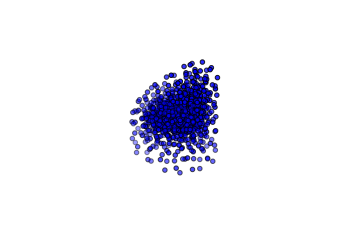

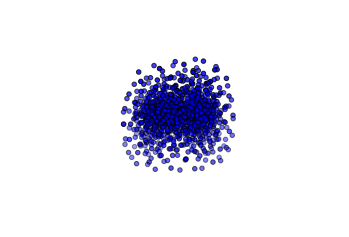

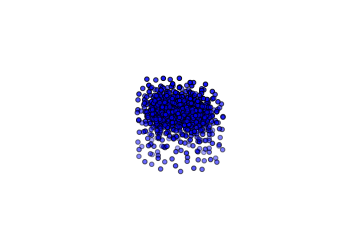

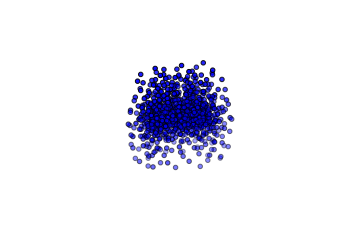

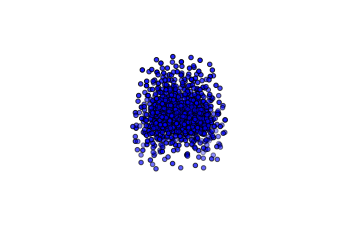

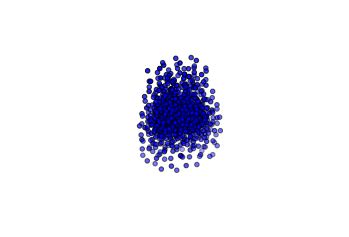

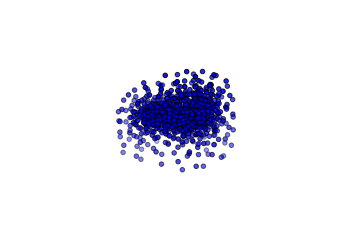

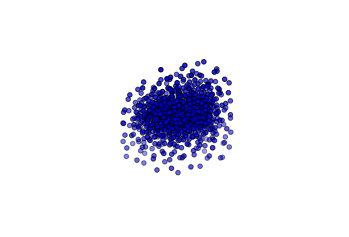

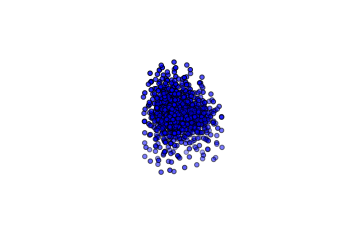

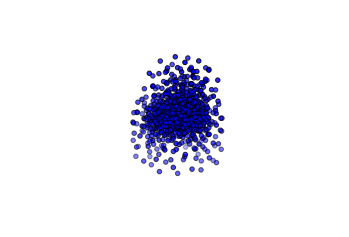

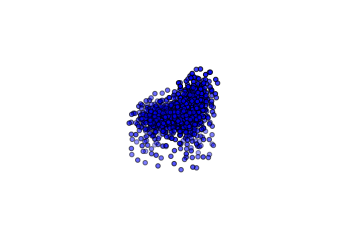

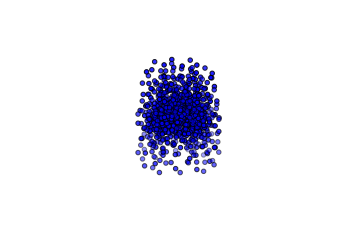

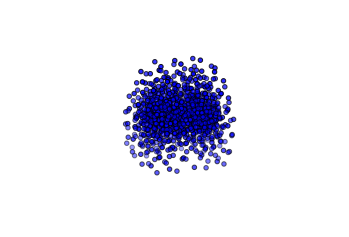

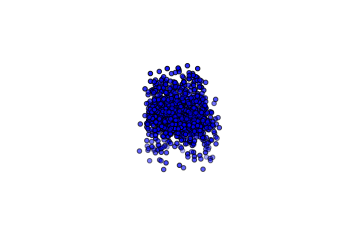

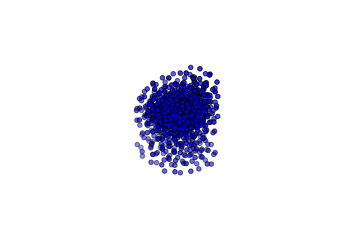

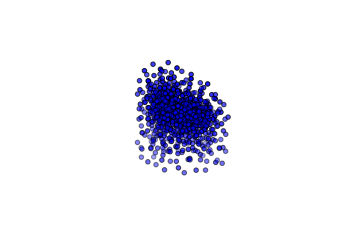

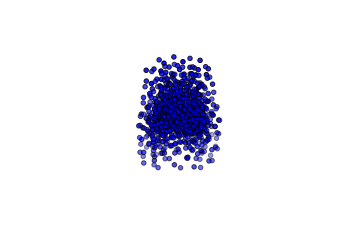

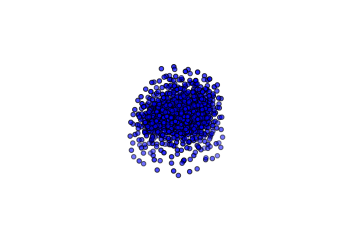

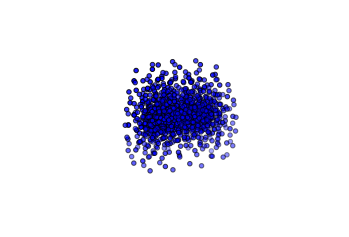

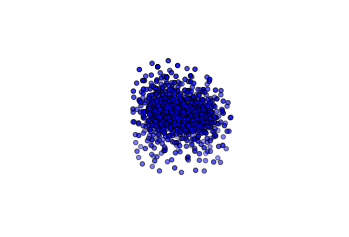

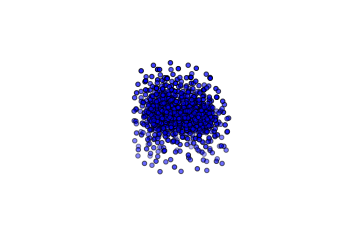

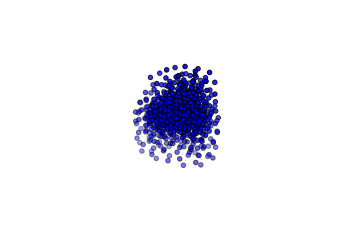

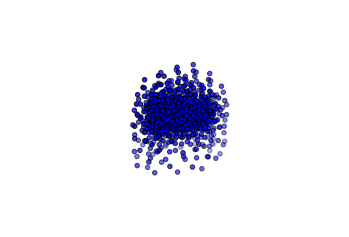

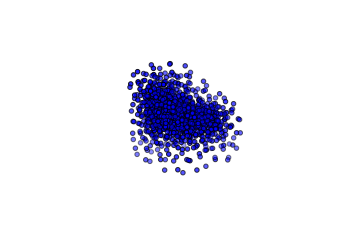

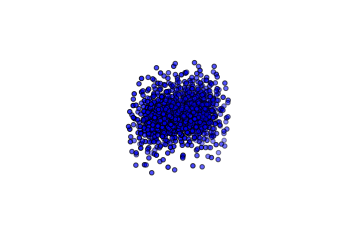

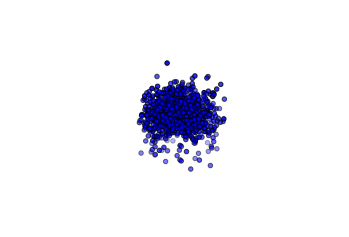

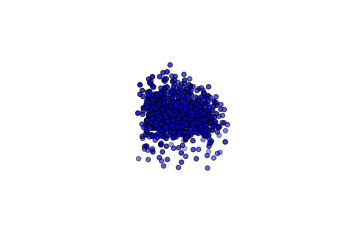

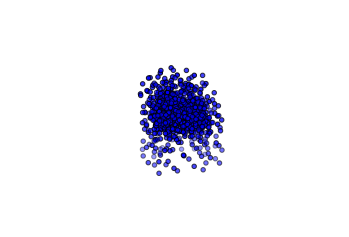

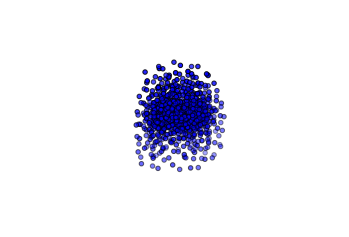

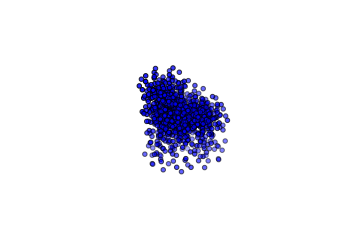

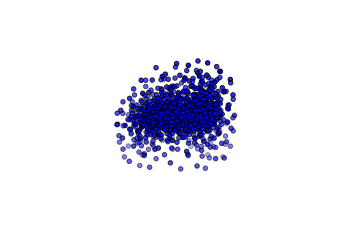

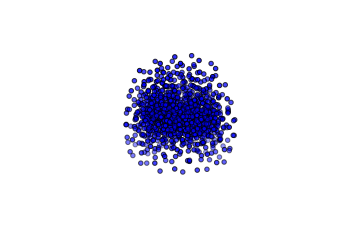

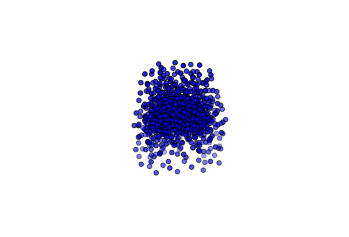

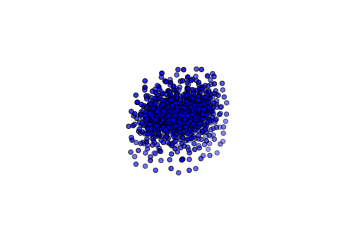

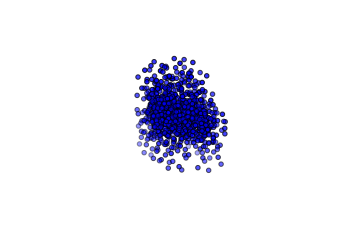

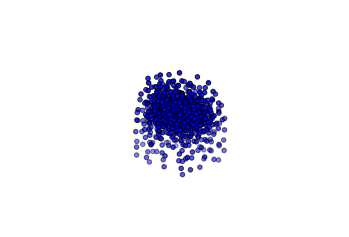

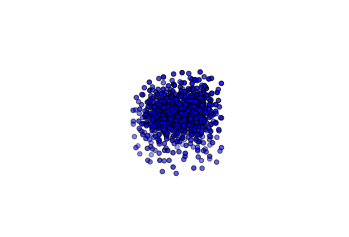

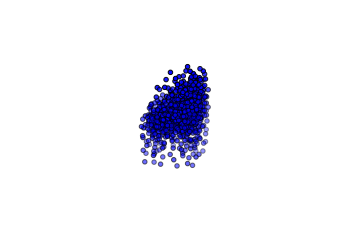

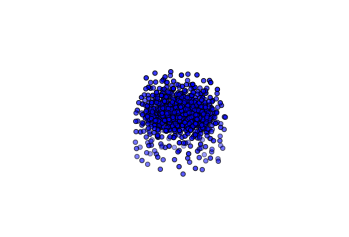

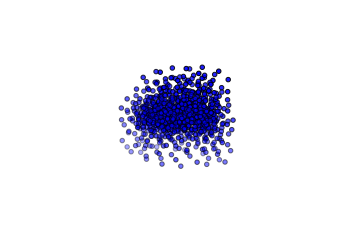

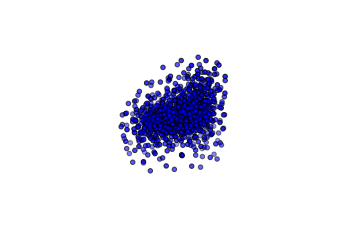

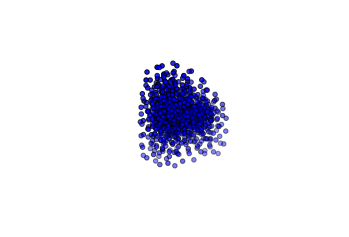

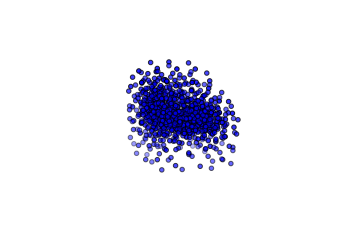

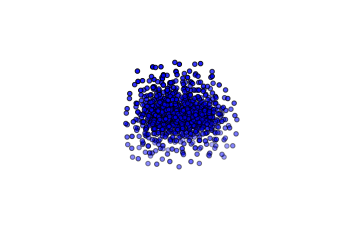

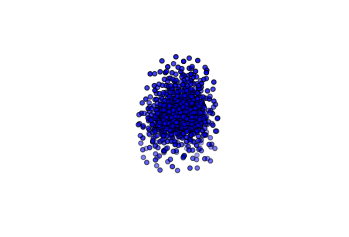

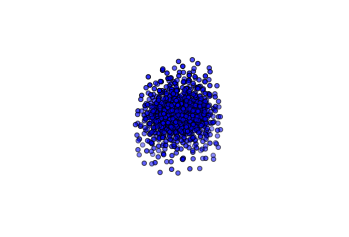

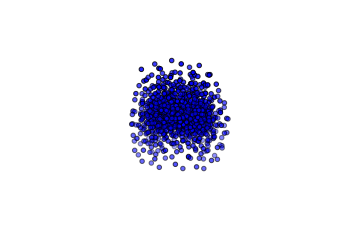

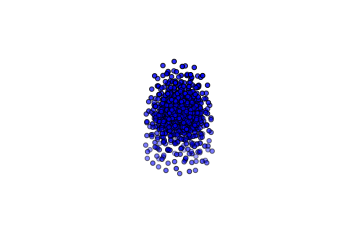

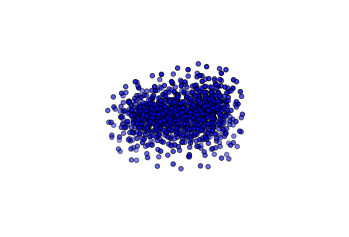

In [88]:
fig = plt.figure(figsize=(16, 10))

# loc = 1
# for p in synthetic_data:
#     pc = Point_Cloud(points=p).center_in_unit_sphere()
#     ax = fig.add_subplot(10, 5, loc, projection='3d')    
#     pc.plot(in_u_sphere=True, axis=ax, show=False);
#     plt.axis('off')
#     loc += 1

loc = 1
for p in synthetic_data:
    pc = Point_Cloud(points=p).center_in_unit_sphere()
#     ax = fig.add_subplot(10, 5, loc, projection='3d')    
    pc.plot(in_u_sphere=True, show=False);
    plt.axis('off')

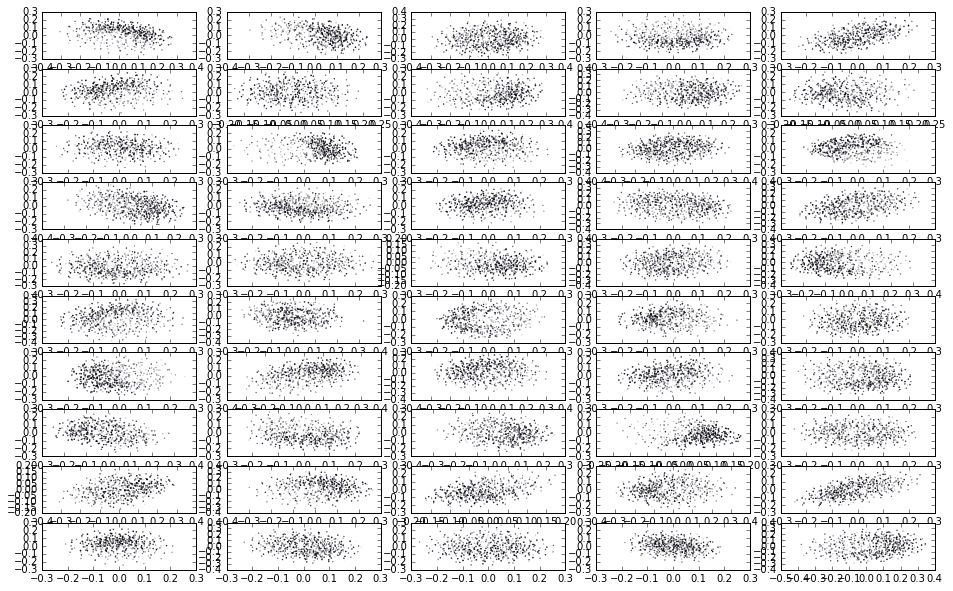

In [84]:
fig